In [1]:
!pip install gym==0.17.1
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym[atari]
!pip install pyvirtualdisplay
!conda install piglet
!pip install pystan
!conda install swig
!pip install box2d-py
!pip install gym[Box_2D]
!pip install Box2D
# !pip3 install pybullet --upgrade

     |████████████████████████████████| 1.6MB 15.7MB/s 
  Created wheel for gym: filename=gym-0.17.1-cp37-none-any.whl size=1648711 sha256=8d097b8a17fb91b9cef16cdca4405b4af5a6c4c217bb1e7224b60d5f31678cb5
  Stored in directory: /root/.cache/pip/wheels/c0/84/61/523b92d88787ae29689b3cc08cf445d8d8186d7fbe1acbf87b
Successfully built gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (851 kB/s)
Selecting previously unselected package python-opengl.
(Reading da

In [2]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


In [3]:

class ReplayBuffer(object):
    def __init__(self, capacity, state_dim):
        self.buffer = deque(maxlen=capacity)
        self.state_dim = state_dim
        
    def __len__(self):
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        '''Add new samples to replay buffer'''
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
        # record the dimension of the state
        
    
    def sample(self, batch_size):
        ''' To Do: sample a batch uniformly from replay buffer, sample without replacement.
            Return a tuple (state_batch, action_batch, reward_batch, next_state_batch, done_batch), where
            state_batch, next_state_batch: 2D numpy array, [batch_size,state_dim]
            action_batch, reward_batch, done_batch: 1D numpy array [batch_size]
            Note : the order in these arrays must be matched. 
            i.e. state_batch = [S_1,S_2,S_3,...S_n]
                 action_batch = [a_1,a_2,a_3....a_n] , n = batch_size, the same for the rest three batches
            Useful function: np.empty() for initializing N-dim array
                             random.sample() for sampling without replacement
        '''
        # first initialize using np.empty()
        state_batch = np.empty([batch_size,self.state_dim[0]])
        action_batch = np.empty([batch_size])
        reward_batch = np.empty([batch_size])
        next_state_batch = np.empty([batch_size, self.state_dim[0]])
        done_batch = np.empty([batch_size])
        # Take #batch_size samples from the replay buffer and write into different arrays.        
        batch = random.sample(range(len(self)),batch_size)
        # To Do here...
        for n in range(batch_size):
          (state, action, reward, next_state, done) = self.buffer[batch[n]]
          state_batch[n] = state
          action_batch[n] = action
          reward_batch[n] = reward
          next_state_batch[n] = next_state
          done_batch[n] = done
          
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch



In [4]:

class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()  
        ''' To Do: Create the following network architecture:
            (1) The first input layer, a fully connected (FC) layer with (input_dim*64), followed by a PReLU layer, see literature for how PRelu works
            (2) A hidden layer, also FC, 64*64, and followed by PRELU
            (3) The output layer, FC layer, (64*number_of_actions) , no activations, as the output approximates the q(s,a)
            Useful function: nn.Sequential() , nn.Linear(), nn.PReLU()
        '''
        self.layers = nn.Sequential(
          nn.Linear(num_inputs,64),
          nn.PReLU(),
          nn.Linear(64,64),
          nn.PReLU(),
          nn.Linear(64,num_actions)
        )
        self.acts = num_actions

        #self.layers.apply(self.init_weights)

    def init_weights(self,m):
      if type(m) == nn.Linear:
        torch.nn.init.constant_(m.weight, -1)
        torch.nn.init.constant_(m.bias, -1)

        
        
    def forward(self, x):
        ''' Retrieve the approximated q(s,a) for the given input x=(s,a)
        '''
        return self.layers(x)
    
    def act(self, state, epsilon):
        ''' To Do: Perform epislon greedy exploration strategy here,
            Return : action index in discrete action space, type(action) = int
            You will need to call the function: self.forward(state)
            Use np.random.random() 
        '''
        # Epsilon-Greedy action selection
        if np.random.random() > epsilon: # Exploit
            return np.argmax(self.forward(torch.from_numpy(state).float()).detach().numpy())
        else:  # Explore
            return np.random.choice([a for a in range(self.acts)])

    def test_act(self, state):
        ''' To Do: Perform greedy action for the current state for the testing phase
            Return : action index in discrete action space, type(action) = int
            You will need to call the function: self.forward(state)

        '''
        return np.argmax(self.forward(torch.from_numpy(state).float()).detach().numpy())



In [5]:

def compute_td_loss(batch_size, replay_buffer, optimizer, device, model, model_target, gamma):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state      = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    '''To Do : Implement the DQN/ DDQN algorithm update rule here 
    You need to define the loss metric as Mean Square Error. 
    The difference between DQN & DDQN is shown in these steps.
    Useful function: in-place operations on tensors 'tensor_a.gather()' , 'tensor_b.unsqueeze()', 'tensor_x.squeeze()' , 'tensor.max()'
    Use : with torch.no_grad() ,  tensor.detach()  to make your td_target have no influence on backward gradient, i.e. semi-gradient on your td_target
    '''
    crit = nn.MSELoss(reduction='mean')# Use MSEloss with mean reduction.




    

    with torch.no_grad():
      #DQN
      next_state_values = model_target(next_state).max(1)[0]
      y_i = (1 - done)*(next_state_values * gamma) + reward#DQN

      #DDQN
      #act_idx = model(next_state).argmax(1).unsqueeze(1)
      #next_state_act_vals = model_target(next_state).gather(1, act_idx)
      #y_i = (1 - done)*(next_state_act_vals.squeeze(1) * gamma) + reward#DDQN


    state_action_values = model(state).gather(1, action.unsqueeze(1))
    loss = crit(state_action_values, y_i.detach().unsqueeze(1))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    return loss


def test(env, model):       
    ''' 
        Testing phase.
        Only for local users, you can uncomment env.render()
    '''
    state = env.reset()
    episode_reward = 0
    # Limit the maximal episode length to avoid infinite loop
    for t in range(1000): 
        action = model.test_act(state)
        next_state, reward, done, _ = env.step(action)    
        #env.render()        
        state = next_state
        episode_reward += reward
        if done == True:                  
            print("test reward : {}".format(episode_reward))
            break


def plot(frame_idx, rewards, losses, task):
    '''
        For monitoring the training process
    '''
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    if task == 1:
        plt.plot(rewards)
    elif task == 2:
        plt.scatter(np.linspace(0,len(rewards)-1,len(rewards)),rewards, s=0.75)
    plt.subplot(122)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


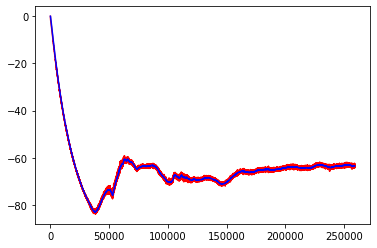

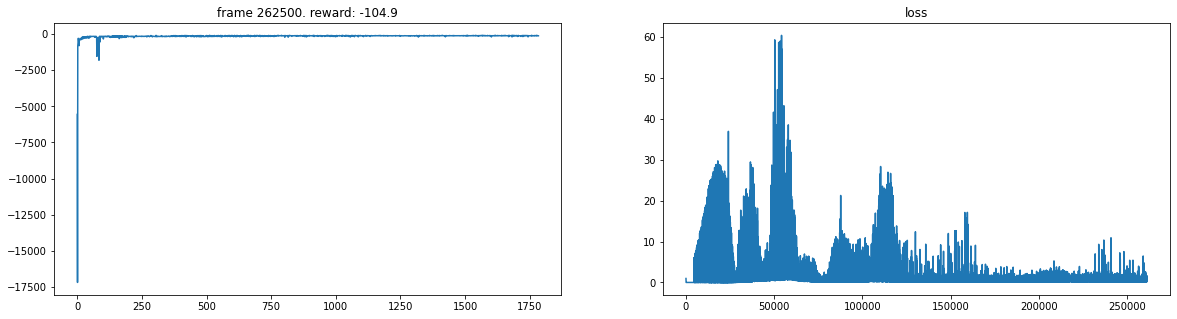

Episode#:1785 reward:-114.0 eps:0.0501504429481476
Episode#:1786 reward:-118.0 eps:0.05014985236812035
Episode#:1787 reward:-88.0 eps:0.050149413445242146
Episode#:1788 reward:-92.0 eps:0.05014895594586765
test reward : -106.0
Episode#:1789 reward:-106.0 eps:0.050148430563580884
Episode#:1790 reward:-108.0 eps:0.050147897174228885
Episode#:1791 reward:-91.0 eps:0.05014744923252211
Episode#:1792 reward:-116.0 eps:0.0501468801963353
Episode#:1793 reward:-101.0 eps:0.05014638653114366
Episode#:1794 reward:-111.0 eps:0.05014584590175956
Episode#:1795 reward:-110.0 eps:0.050145312112664486
Episode#:1796 reward:-117.0 eps:0.05014474649908848
Episode#:1797 reward:-102.0 eps:0.05014425519667897
Episode#:1798 reward:-92.0 eps:0.050143813491702945
test reward : -111.0
Episode#:1799 reward:-113.0 eps:0.05014327281313476
Episode#:1800 reward:-109.0 eps:0.05014275319978291
Episode#:1801 reward:-160.0 eps:0.050141993876047244
Episode#:1802 reward:-110.0 eps:0.050141474185183894
Episode#:1803 reward:

KeyboardInterrupt: ignored

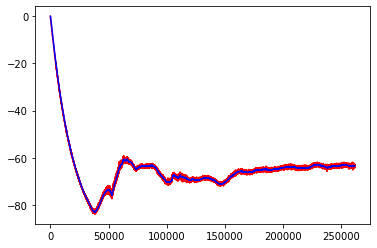

In [6]:

if __name__ == "__main__":    
    '''
        Important: The maximal number of interactions: num_frames = 1000000,
        But it is definitely NOT NECESSARY to ran until the end.
        If the training episodic reward already converges >-150, then you can STOP the program.
        It takes roughly 10 minutes to get converged to episodic reward >-150 in Colab. 
        You need to write code to save the statistics at the last line of the program.       
    '''
    task = 1 # to modify for different task
    if task == 1:
        env = gym.make('MountainCar-v0').env # the suffix .env removes the constraint of maximal episodic length of 200 steps 
    elif task == 2:
        env = gym.make('LunarLander-v2') # An episode will be forced to terminate after 1000 steps in this env setting.
    print(env.observation_space, env.action_space)   #observation_space and action space
    
    
    # Initialize the Deep Q-networks
    model = DQN(env.observation_space.shape[0], env.action_space.n)
    # Declare target network, initialize it 
    model_target = DQN(env.observation_space.shape[0], env.action_space.n)
    
    # -->To Do: Copy the weights from model to model_target using 'load_state_dict'
    model_target.load_state_dict(model_target.state_dict())

    
    # Put networks to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model_target = model_target.to(device)
    
    # Initialize the optimizer for learning the weights of Neural Network
    optimizer = optim.Adam(model.parameters(), lr = 0.001)    
    if task == 1: 
        batch_size = 64
        test_every_N_training_episode = 10
        start_train = 1000
        
        # Initialize the exploration strategy/coefficient
        epsilon_start = 1.0
        epsilon_final = 0.05 # to ensure sufficient exploration 
        epsilon_decay = 30000 
        epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)  
        # Plot the exploration rate w.r.t. number of steps (frame_index) the agent has traversed. 
        plt.plot([epsilon_by_frame(i) for i in range(100000)])
        
    elif task == 2:
        batch_size = 64
        test_every_N_training_episode = 10
        # Only start training when there is a sufficient number of experience stored in replay buffer
        start_train = 3000 
        
        # Initialize the exploration strategy/coefficient
        epsilon_start = 1.0
        epsilon_final = 0.05 # to ensure sufficient exploration 
        epsilon_decay = 50000 
        epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)  
        # Plot the exploration rate w.r.t. number of steps (frame_index) the agent has traversed. 
        plt.plot([epsilon_by_frame(i) for i in range(100000)])
        
    # Initialize the replay buffer with the maximal storage of 1000000 experience/interactions
    replay_buffer = ReplayBuffer(600000, env.observation_space.shape)    

    gamma = 0.99 # discount factor

    # Statistics 
    losses = []
    all_rewards = []
    episode_reward = 0
    episode_count = 0
    episodic_step_count = 0
    
    # -----state_trail is the initial state whose estimated q-value will be examined.----- 
    state_trial = env.reset()
    state_trial = torch.FloatTensor(np.float32(state_trial)).to(device)
    est_Q_values_running_network = []
    est_Q_values_target_network = []
       
    #---------------------Training----------------------
    # You don't need to run 0.5M frames, you could terminate earlier when the return is around -150. Save the statistics of episodic returns and predicted Q-values
    num_frames = 500000 # maximal number of interactions, similar to N_episodes in previous assignments 
    
    state = env.reset()
    for frame_idx in range(1, num_frames + 1):
        # determine the exploration rate for this step
        epsilon = epsilon_by_frame(frame_idx)
        # Take an action according to exploration strategy
        action = model.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        episodic_step_count += 1
        # Add the experience to the replay buffer
        if task == 1:
            replay_buffer.push(state, action, reward, next_state, done)       
        elif task == 2:
            # If terminate due to reaching max epi length, we put done as False to replay buffer so to allow bootstrapping of next successor state
            if episodic_step_count == env._max_episode_steps:  
                replay_buffer.push(state, action, reward, next_state, False)
            else:
                replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward       
        
        if done:
            all_rewards.append(episode_reward)
            print("Episode#:{} reward:{} eps:{}".format(episode_count,
                                     episode_reward, epsilon))
            episode_reward = 0
            episode_count += 1
            episodic_step_count = 0
            # ---------------------Test Phase--------------------
            if len(all_rewards)%test_every_N_training_episode == test_every_N_training_episode-1:
                test(env, model)
            #----------------------------------------------
            state = env.reset()
            
            
        # Ensure there are enough samples in the replay buffer, then start training the network    
        if len(replay_buffer) > start_train:
            loss = compute_td_loss(batch_size, replay_buffer, optimizer, device, model, model_target, gamma)
            losses.append(loss.detach().cpu().numpy())
            # -------------check the estimated Q-value for initial state on both running network and target network--------------
            with torch.no_grad():
                est_Q_values_running_network.append(np.max(model(state_trial).cpu().numpy()))
                est_Q_values_target_network.append(np.max(model_target(state_trial).cpu().numpy()))
         
        # update target network                         
        if task == 1: 
            # To Do : Perform soft update (Polyak averaging) with tau = 0.005 
            # Soft update # Refer to the post from Navneet_M_Kumar under https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/16 for answer   
            tau = 0.005        
            for target_param, param in zip(model_target.parameters(), model.parameters()):
              target_param.data.copy_(tau*param.data + target_param.data*(1.0 - tau))
        elif task == 2: 
            # To do: hard update the target network every 3000 interactions. Useful variable: frame_idx
            if frame_idx % 3000 == 0:    
              for target_param, param in zip(model_target.parameters(), model.parameters()):
                target_param.data.copy_(param.data)
         
        if frame_idx % 2500 == 0:
            plot(frame_idx, all_rewards, losses, task)
            plt.plot(np.array(est_Q_values_running_network), color = 'r')
            plt.plot(np.array(est_Q_values_target_network), color = 'b')
            # --> To Do: You can save the statistics here, using np.save()
            # You could first convert all_rewards and losses into np.array, and save as .npy.file
            
            
            
